# End-to-end Example

This notebook runs through a long-ish example of using the modules to analyze some survey data.

## Imports and setup

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import json
import random
from typing import Any
from pprint import pprint
from IPython.display import Markdown, display, HTML
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
from survey_analysis.summarization import summarize_comments
from survey_analysis.theme_derivation import derive_themes
from survey_analysis.sentiment_analysis import (
    classify_sentiment, 
    sort_by_confidence,
    SentimentAnalysisResult
)
from survey_analysis.excerpt_extraction import extract_excerpts
from survey_analysis.multilabel_classification import multilabel_classify, default_tags_list

%matplotlib inline

In [4]:
# this makes it more robust to run async tasks inside an already async environment (jupyter notebooks)
import nest_asyncio
nest_asyncio.apply()

Make sure to either set `OPENAI_API_KEY` as an environment variable or put it in a .env file and use the following cell to load the env var. The format in the .env file is:
```
OPENAI_API_KEY=yourKeyGoesHere
```

In [5]:
load_dotenv(find_dotenv())

True

In [6]:
%load_ext autoreload
%autoreload 2

This is a convenience function to make seeing Pandas dataframe values easier, especially when there are long strings like the student comments we will be using.

In [7]:
def full_show(df):
    with pd.option_context('display.max_columns', None, 'display.max_rows', None, 'display.max_colwidth', None):
        display(df)

This is a convenience function for pretty-printing long student comments.

In [8]:
def print_wrap(text: str, width: int = 72) -> str:
    print(textwrap.fill(text, width=width))

## Load the example data

In [9]:
data_path = Path('../data/example_data')

Let's load up some fake data. 

All of these comments are synthetic to avoid sharing any sensitive or PII information, but they should work great for illustration purposes. There are 100 rows, with just a few null/nan values here and there for realism. In most surveys I've seen, there are quite a number of null/None/blank etc values, so the functions here are written to handle those.

In [10]:
example_survey = pd.read_csv(data_path / 'example_survey_data_synthetic.csv')
full_show(example_survey.head())

,best_parts,enhanced_learning,improve_course
0,I valued the practical clinical aspects related to immune-related disorders and their management.,The illustrative visuals and straightforward explanatory clips.,Consider reducing the duration of certain videos. A few appeared to be slightly prolonged.
1,The flexibility to learn at a self-determined speed,The opportunity to review the lecture content,"The pace of some lectures could be slowed down. At times, it's challenging to follow the lecturer's speech or decipher their handwriting."
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,the self-assessment activities.,Nothing specific comes to mind.
3,Professional growth within the medical sector,"The practical integration workshops were highly beneficial, they significantly contributed to a deeper comprehension of the theories and their implementation in a healthcare environment.",Incorporating a few advanced projects as optional tasks could benefit learners who wish to delve deeper into the subject matter. These projects wouldn't need to influence exam scores.
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The aspect of the course that most facilitated my learning was the regular assessments provided at each segment, which helped confirm my grasp of the material presented. These checkpoints effectively guided me in the correct learning direction. It's evident that considerable effort was invested in designing these educational modules to enable students to gain a deep comprehension rather than just a superficial understanding of the subject matter.","Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved. Additionally, consider introducing an additional educator to the mix. The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."


## Plan

We're going to analyze to some example survey questions. The main overall goals are to show how one might explore the following questions:

1. What did students say about the course? (themes, summarization)
2. How did they feel about the course? (sentiment analysis)
3. What did they say about some aspect of interest? (extraction)
4. How did they feel about that aspect (focused sentiment analysis)
5. How many comments were there about different aspects? (multilabel classification)

If you're interested in this sort of thing, have a look at the paper called [A Large Language Model Approach to Educational Survey Feedback Analysis](https://arxiv.org/pdf/2309.17447.pdf) (shameless self plug). 

For the survey we'll be analyzing, there were three survey questions of interest. We'll define the questions themselves in variables for use later. We'll use these as metadata when passing along comments to the LLM routines. This is potentially important context for an LLM...after all, the survey comment "The flexibility to learn at a self-determined speed" may have different significance if the question was "What were the best parts of the course?" versus "What could be improved about the course?".

In [13]:
best_parts_question = "What were the best parts of the course?"
enhanced_learning_question = "What parts of the course enhanced your learning the most?"
improve_course_question = "What could be improved about the course?"

## 1. What did students say about the course?

When confronted with survey results, this is the high-level (vibes) step of getting a feel for what the major pieces of feedback were. Each question has its own context, so we'll analyze the results from each question separately. We'll look at a bottom-up approach versus a top-down approach.

### Theme derivation (bottom-up approach)

Here we'll come in without preconceived notions or categories and let the model derive the themes (from the bottom up, based on the comments). We'll also look at summarization as an alternative. Let's find the themes (common feedback expressed by multiple students), first from the "What were the best parts of the course?" survey question and then from the "What could be improved about the course?" question. The derive_themes function runs three passes by default, shuffling the order of the comments, given that the output for any single LLM run seems to depend on the order of the comments. For each pass, the model merges and distills the themes with the themes from the prior passes. (If you're running this, be patient - it may take 3-5 minutes for 100-200 comments). For complex tasks like this, gpt-4-turbo shines more than gpt-3.5-turbo and may even be necessary.

In [13]:
best_parts_comments = example_survey['best_parts'].tolist() 
best_parts_themes = await derive_themes(comments=best_parts_comments, 
                                        question=best_parts_question, 
                                        shuffle_passes=3) # this defaults to 3 passes but just making it explicit here

pass 1
title: Practical Applications
description: Students appreciated the practical application segments of the lessons, which helped deepen their understanding of complex scientific concepts and their relevance to real-world health conditions.

title: Visual and Interactive Content
description: Visual aids, including videos, animations, and interactive modules, were highlighted as engaging and effective in simplifying complex topics and enhancing learning.

title: Flexibility and Self-Paced Learning
description: Students valued the course's flexibility, allowing them to learn at their own pace, which was particularly beneficial for those balancing other commitments.

title: Comprehensive and Engaging Content
description: The course content was praised for being comprehensive, covering a wide range of topics in depth, and engaging, with students appreciating the integration of theoretical knowledge with practical clinical applications.

title: Instructor Quality
description: The quali

Let's see the titles of the themes derived.

In [14]:
for theme in best_parts_themes.updated_themes:
    print(theme.theme_title)

Practical Applications in Medical Practice
Engaging and Visual Learning Experience
Comprehensive Educational Approach
Assessment, Feedback, and Interactive Quizzes
Exceptional Instructor Quality
Clinical Relevance


Now let's take a look at the model's reasoning in combining themes along the way, across the different passes, and then get more detail on the final themes.

In [22]:
print('Reasoning:')
print_wrap(best_parts_themes.reasoning)
print('\nFinal Themes:\n')
for theme in best_parts_themes.updated_themes:
    print(f'Title: {theme.theme_title}')
    print_wrap(f'Description: {theme.description}')
    print('\n')

Reasoning:
1. 'Enhanced Practical Applications' and 'Practical Applications' cover
the same topic of practical application aspects in the course, including
laboratory exercises, case studies, and real-world scenarios, making
them suitable for merging.  2. 'Visual, Interactive, and Engaging
Learning', 'Engaging Content', 'Instructional Videos', and 'Visual Aids'
all discuss the use of visual and interactive elements such as videos,
animations, and hands-on activities to make learning more engaging and
effective. These themes are closely related and can be merged.  3.
'Comprehensive and Engaging Curriculum' and 'Comprehensive Resources'
both highlight the comprehensive nature of the course material,
including the range of resources provided and the structured progression
of topics. Merging these themes would create a more unified view of the
course's comprehensive educational approach.  4. 'Interactive Quizzes'
is closely related to the assessment and feedback mechanisms discussed
in 'As

Let's do the same thing for the feedback comments for the survey question "What could be improved about the course?".

In [25]:
improve_course_comments = example_survey['improve_course'].tolist() 
improve_course_themes = await derive_themes(comments=improve_course_comments, 
                                            question=improve_course_question)

pass 1
title: Video Duration
description: Feedback indicates a need for adjustments in video duration, with some students finding certain videos either too lengthy or too brief for effective learning.

title: Pace of Lectures
description: Several comments suggest that the pace of some lectures is too fast, making it difficult for students to follow along and fully understand the material presented.

title: Advanced Projects
description: Students expressed interest in having optional advanced projects to further explore the subject matter, indicating a desire for deeper engagement with the course content.

title: Multiple Instructors
description: Feedback suggests that incorporating multiple instructors into the course could enhance the learning experience by providing varied perspectives and preventing monotony.

title: Comprehensive Discussions
description: Students are seeking more comprehensive discussions on certain topics, indicating a need for the course to cover subject matter m

First let's take a look at the titles of the themes derived.

In [33]:
for theme in improve_course_themes.updated_themes:
    print(theme.theme_title)

Enhanced Video Lectures and Content
Comprehensive Practical and Interactive Components
Improved Clarity and Accessibility
Aligned and Expanded Assessments
Advanced Projects
Multiple Instructors
Comprehensive Discussions
Visual Aids
Improve Course Content


...and some more detail about the themes and the reasoning for combining themes.

In [34]:
print('Reasoning:')
print_wrap(improve_course_themes.reasoning)
print('\nFinal Themes:\n')
for theme in improve_course_themes.updated_themes:
    print(f'Title: {theme.theme_title}')
    print_wrap(f'Description: {theme.description}')
    print('\n')

Reasoning:
Themes 'Enhanced Video Lectures and Pace' and 'Enhanced Video Content'
are merged because they both address the need for improvements in video
lectures, including aspects like clarity, pace, and content depth. The
themes 'Comprehensive Practical Components' and 'Expanded Interactive
Content' are merged because they both emphasize the need for more
engaging, practical, and interactive elements in the course, such as
simulations and hands-on activities. The rest of the themes are unique
in their focus and do not overlap significantly with others, thus they
remain unmerged.

Final Themes:

Title: Enhanced Video Lectures and Content
Description: This theme combines feedback on the need for adjustments in
video lectures, including their duration, pace, clarity, and the
inclusion of more detailed subjects. Suggestions include reducing the
length of some videos, slowing down the pace of lectures to improve
understanding, enhancing the overall clarity of video content, and
adding mo

### Summarization

Here's an alternate approach that summarizes a group of comments to come up with themes. We'll just do this for the "What could be improved about the course?" question. The output is less structured than for theme derivation, so it would be a bit harder to pull out the themes automatically into a spreadsheet (or as a basis for classification...what we'll do after this).

In [35]:
improve_course_summarization_result = await summarize_comments(comments=improve_course_comments, 
                                                               question=improve_course_question)

display(Markdown((improve_course_summarization_result.summary)))

The feedback highlights several areas for improvement across different aspects of the course:

1. **Pacing and Content Delivery**: There's a consensus on the need for adjusting the pace of lectures and videos. Some students find certain videos too lengthy or too brief, suggesting a need for better tailoring of video duration to the complexity of the topic. Additionally, the rapid pace of instructional videos makes it difficult for some students to follow along.

2. **Depth and Variety of Content**: Students expressed a desire for more in-depth exploration of topics, including advanced projects, more comprehensive discussions on specific subjects (e.g., cancer treatments, immunotherapy), and the inclusion of more practical exercises and case studies. There's also a call for expanding the curriculum with additional subjects and incorporating more visual aids to enhance understanding.

3. **Assessment and Instructional Materials**: Feedback indicates a need for better alignment between course content and assessments, with some students finding quizzes and final assessments either too challenging or not reflective of the course material. Suggestions include more mock tests, clarification of quiz objectives, and ensuring all tested subjects are covered in the course material. Additionally, there's a request for more interactive elements and practical demonstrations.

4. **Accessibility and Engagement**: Students would appreciate more engaging activities, the inclusion of multimedia presentations, and tools like live tutoring during video playback. There's also a call for making learning materials more accessible, such as providing downloadable PDFs, improving the clarity of video lectures, and adding subtitles in other languages.

5. **General Satisfaction and Miscellaneous**: While many students are satisfied with the course, pointing out its exceptional quality and organization, they also suggest minor improvements like adjusting the typeface for better readability, ensuring consistency in language across presentations, and expanding the use of practical examples.

When I ran this for the example, the model happened to format the output in Markdown, so that's the way I'm displaying it above. The themes are not exactly the same as what we came up with from theme derivation, but that's to be expected. The content of them, if you read the descriptions, is pretty similar to what we saw from theme derivation.

One thing the derived themes leave hanging is how many students actually remarked on each theme. We'll address that in the last part of this notebook using multilabel classification.

## 2. How did students feel about the course?

### Sentiment analysis

Figuring out students' sentiment can give an overall sense of the comments and help prioritize which ones might be actionable or let you see what aspects provoked the most positive or negative comments. There are other ways of getting people's overall sentiment, for example net promoter score or Likert scales, but there is additional information from sentiment. For example, it is not uncommon to see a person give a good net promoter score but provide some critical feedback in certain survey question columns.


Here we classify the comments that were in response to the question about the best parts of the course.

In [41]:
best_parts_sentiment_results = await classify_sentiment(comments=best_parts_comments, question=best_parts_question)

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 8.166216135025024


We can first take a look at some verbose output, but the main thing to pay attention to is the sentiment and the fine_grained_sentiment_category. The sentiment for each comment is 'positive', 'negative', or 'neutral', and the fine grained sentiment further subdivides neutral into 'neutral-positive', 'neutral', or 'neutral-negative'. We'll look at the sentiment of the comments in a more visual way shortly, but here is the more detailed output of the comments from most positive to most negative.

In [42]:
best_parts_pairs = sort_by_confidence(best_parts_comments, best_parts_sentiment_results)
for comment, result in best_parts_pairs:
    print(f'Student comment: "{comment}"')
    pprint(json.loads(result.model_dump_json(exclude={'logprobs'})))
    print('\n')

Student comment: "The educational content was extremely enriching and stimulating! The section on oncology was the highlight."
{'classification_confidence': {'difference': 'Infinity',
                               'next_token': None,
                               'top_token': 'positive'},
 'fine_grained_sentiment_category': 'positive',
 'reasoning': "The comment uses enthusiastic language such as 'extremely "
              "enriching and stimulating' to describe the educational content, "
              'indicating a high level of satisfaction. The mention of the '
              "oncology section as a 'highlight' further emphasizes the "
              'positive experience the student had with the course.',
 'sentiment': 'positive',
 'sentiment_logprobs': [{'linear_prob': 100.0,
                         'logprob': 0.0,
                         'token': 'positive'},
                        {'linear_prob': 0.0,
                         'logprob': -17.53125,
                         'toke

We will also run sentiment analysis over the survey feedback about how the course can be improved before visualizing both to compare.

In [43]:
improve_course_sentiment_results = await classify_sentiment(comments=improve_course_comments, question=improve_course_question)

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 10.377526998519897


...and check out the ranking of the comments along with the detailed reasoning of the logic behind why each comment was classified that way.

In [44]:
improve_course_pairs = sort_by_confidence(improve_course_comments, improve_course_sentiment_results)
for comment, result in improve_course_pairs:
    print(f'Student comment: "{comment}"')
    pprint(json.loads(result.model_dump_json(exclude={'logprobs'})))
    print('\n')

Student comment: "It's excellent."
{'classification_confidence': {'difference': 'Infinity',
                               'next_token': None,
                               'top_token': 'positive'},
 'fine_grained_sentiment_category': 'positive',
 'reasoning': "The comment uses the word 'excellent' to describe the course, "
              'which is a strong positive adjective, indicating satisfaction '
              'or high quality.',
 'sentiment': 'positive',
 'sentiment_logprobs': [{'linear_prob': 100.0,
                         'logprob': -3.1281633e-07,
                         'token': 'positive'},
                        {'linear_prob': 0.0,
                         'logprob': -15.3125,
                         'token': 'Positive'},
                        {'linear_prob': 0.0,
                         'logprob': -17.0,
                         'token': ' positive'}]}


Student comment: "This course is already excellent and does not require enhancements. I feel that it successful

### Displaying the sentiment results

Just for visualization sake, we create a display helper function for pretty output ranked by sentiment from most positive to most negative (from blue to red). This color theme is best viewed on a dark background (dark theme).

In [97]:
color_map = {'positive': 'MediumSlateBlue', 
            'neutral-positive': 'LightSkyBlue',
            'neutral': 'Snow',
            'neutral-negative': 'LightSalmon',
            'negative': 'Red'}

def colorized_html_output(pairs: tuple[str, SentimentAnalysisResult]) -> Any:
    html_output = ""
    for comment, result in pairs:
        color = color_map[result.fine_grained_sentiment_category]
        html_output += f'<span style="color:{color}; font-size:1.2em">"{comment}"</span><br>'

    return HTML(html_output)

def reference_colors():
    """This is kind of like a legend for the colorized_html_output"""
    html_output = ""
    for category, color in color_map.items():
        html_output += f'<span style="color:{color}; font-size:1.2em">{category}</span><br>'

    return HTML(html_output)

In [48]:
display(reference_colors())

Let's look at the best parts comments visualized. We'll choose a random subset to make the output less lengthy, but it should give us a good idea of the proportion of comments falling into each category. (I'm setting a random seed so you see the same random subset when you run this on your own, but feel free to comment that out.) If you want to see the full output, comment out the first four lines and uncomment the last line.

In [61]:
random.seed(1)
random_indices = random.sample(range(len(best_parts_pairs)), 50)
random_indices.sort()
display(colorized_html_output(best_parts_pairs[i] for i in random_indices))
# display(colorized_html_output(best_parts_pairs))

Interesting...overwhelmingly positive (as we would expect, based on the question), but you can see that the neutral-positive ones contain some "however..." mixed feedback. Now let's compare with a random subset of the comments from the question about improving the course.

In [63]:
random.seed(1)
improve_random_indices = random.sample(range(len(improve_course_pairs)), 50)
improve_random_indices.sort()
display(colorized_html_output(improve_course_pairs[i] for i in improve_random_indices))

That makes sense! You would expect asking for suggestions for improvement to elicit some comments that could be more negative, and you can see, based on the colors, how the sentiment has shifted relative to the best parts comments.

Just a note that for sure using an LLM is not the only way to do sentiment analysis, but some of the specialized models out there that I tried didn't match up against human intuition/ratings all that well, perhaps based on the fact that tweets (or similar training data) are fairly different than course reviews.

## 3. What did students say about some aspect of interest? (extraction)

In this case, let's say we want to know what suggestions for improvement students had about the lectures and videos. We can define that as our goal focus and pass that along.

In [82]:
goal_focus = "lectures and videos"
lec_vid_excerpts = await extract_excerpts(comments=improve_course_comments,
                                          question=improve_course_question,
                                          goal_focus=goal_focus)

# we'll just look at the first 10 comments and their excerpts
for comment, excerpts in list(zip(improve_course_comments, lec_vid_excerpts))[:10]:
    print_wrap(f'Student comment: "{comment}"')
    pprint(excerpts.model_dump())
    print('\n')

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 9.49645471572876
Student comment: "Consider reducing the duration of certain videos. A
few appeared to be slightly prolonged."
{'excerpts': ['Consider reducing the duration of certain videos. A few '
              'appeared to be slightly prolonged.']}


Student comment: "The pace of some lectures could be slowed down. At
times, it's challenging to follow the lecturer's speech or decipher
their handwriting."
{'excerpts': ["The pace of some lectures could be slowed down. At times, it's "
              "challenging to follow the lecturer's speech or decipher their "
              'handwriting.']}


Student comment: "Nothing specific comes to mind."
{'excerpts': []}


Student comment: "Incorporating a few advanced projects as optional
tasks could benefit learners who wish to delve deeper into the subject
matter. These projects wouldn't need to influence exam s

That seemed to work well. You can see from looking at the output of how it did extraction on the first 10 of the comments that it honed in on the parts about the lectures and vides. As an example, the comment

> "Extend the duration of the concept videos for the more
challenging topics, as they require a deeper dive to fully grasp the
intricacies involved. Additionally, consider introducing an additional
educator to the mix. The dynamic of having multiple voices in another
subject area is quite engaging, and it would be beneficial to replicate
that experience in this subject to prevent monotony from setting in with
just one instructor."

had excerpts:

> "Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved."
              
and

> "The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."

with the first having to do with videos and the second one having to do with lectures.

## 4. How did they feel about that aspect (focused sentiment analysis)

Now we can analyze the sentiment of the excerpts for a more nuanced picture. Remember, these are in response to the "how can the course be improved?" question, so we would expect a bit more of a negative skew, given that that is the way the question is oriented.

In [95]:
# first get all the excerpts in a single flattened list
from itertools import chain
lec_vid_excerpts_flat = list(chain.from_iterable(result.excerpts for result in lec_vid_excerpts if result.excerpts))
lec_video_sentiment_results = await classify_sentiment(comments=lec_vid_excerpts_flat, 
                                                       question="How could the lectures and videos be improved?")

processing 22 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 6.83613395690918


...and check out the ranking of the comments along with the detailed reasoning of the logic behind why each comment was classified that way.

In [96]:
lec_vid_sentiment_pairs = sort_by_confidence(lec_vid_excerpts_flat, lec_video_sentiment_results)
for excerpt, result in lec_vid_sentiment_pairs:
    print(f'Excerpt: "{excerpt}"')
    pprint(json.loads(result.model_dump_json(exclude={'logprobs'})))
    print('\n')

Excerpt: "The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."
{'classification_confidence': {'difference': 7.000000110039999,
                               'next_token': 'neutral',
                               'top_token': 'positive'},
 'fine_grained_sentiment_category': 'positive',
 'reasoning': 'The comment suggests an improvement by incorporating multiple '
              'voices to enhance engagement, indicating the student sees value '
              'in the current setup but believes diversity in instruction '
              "could further improve the experience. The use of 'quite "
              "engaging' and 'beneficial' reflects a positive outlook towards "
              "the course's potential improvement.",
 'sentiment': 'positive',
 'sentiment_logprobs': [{'linear_prob': 99.91,
                         'logprob'

In [98]:
display(reference_colors())

In [99]:
display(colorized_html_output(lec_vid_sentiment_pairs))

Not bad...the overall sentiment distribution is pretty similar to the sentiment distribution of the "how can the coures be improved?" comments we looked at previously. The excerpts are sometimes brief and judging sentiment in a fine-grained way is not so easy. But you can imagine that if you had one thousand such excerpts, having some judgment of sentiment might help you prioritize.

## 5. How many comments were there about different aspects? (multilabel classification)

Here we get into quantification of what comments were about. It would be helpful to have that kind of quantification, particularly if we're trying to use the data to help with decisions about whether it's worth it to devote resources (including time and energy) to make changes to the course based on the feedback.

There are (at least) a couple of ways we can go about quantifying. One is to continue the bottom-up approach and use the themes derived from the comments themselves to classify the comments. The second way is what I would label top-down, which essentially means using a pre-defined set of tags or labels. These are based on major areas of interest that are applicable to many types of courses. Using a pre-defined set of tags also allows better comparison across cohorts as you act on feedback and make iterative changes to a course.

### Mult-label classification (bottom-up tags)

Let's use the theme derivation results to quantify how many comments were about each theme. The themes weren't intended as category labels, but we can effectively use them that way and classify the comments using multilabel classification.  

First we'll turn the themes derived from the 'best parts' comments into the format needed (a list of dictionaries). We could also load tags from a file, as we'll see when we do the top-down approach.

In [101]:
best_parts_tags = [{'topic': theme.theme_title, 'description': theme.description}
                  for theme in best_parts_themes.updated_themes]

best_parts_tags

[{'topic': 'Practical Applications in Medical Practice',
  'description': "This theme highlights the course's emphasis on practical applications, including laboratory exercises, case studies, real-world patient scenarios, and the application of theoretical knowledge in real-world scenarios, underscoring how these aspects helped students grasp fundamental ideas and their significance in medical practice."},
 {'topic': 'Engaging and Visual Learning Experience',
  'description': 'This theme encompasses the use of visual aids, interactive elements, and engaging content, including videos, animations, educational videos, instructional videos, hands-on activities, and practical case studies, to make the course more engaging and effective in simplifying complex topics.'},
 {'topic': 'Comprehensive Educational Approach',
  'description': 'This theme merges the aspects of comprehensive coverage of topics, structured progression, cutting-edge treatments, and the integration of theoretical knowled

Next we do the classification on the same comments that we derived the themes from.

In [104]:
mlc_best_parts_bottomup = await multilabel_classify(comments=best_parts_comments, 
                                                    tags_list=best_parts_tags)

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 18.463132858276367


Let's look at the output classifications, along with the model's reasoning for each. Any categories that are selected have 1 as the value.

In [105]:
for comment, classification in zip(best_parts_comments, mlc_best_parts_bottomup):
    pprint(comment)
    pprint(json.loads(classification.model_dump_json()))

('I valued the practical clinical aspects related to immune-related disorders '
 'and their management.')
{'categories': {'Assessment,_Feedback,_and_Interactive_Quizzes': 0,
                'Clinical_Relevance': 0,
                'Comprehensive_Educational_Approach': 0,
                'Engaging_and_Visual_Learning_Experience': 0,
                'Exceptional_Instructor_Quality': 0,
                'Practical_Applications_in_Medical_Practice': 1},
 'reasoning': 'The comment specifically mentions valuing the practical '
              'clinical aspects of immune-related disorders and their '
              "management, which directly aligns with the category 'Practical "
              "Applications in Medical Practice' due to its focus on "
              'practical, clinical applications.'}
'The flexibility to learn at a self-determined speed'
{'categories': {'Assessment,_Feedback,_and_Interactive_Quizzes': 0,
                'Clinical_Relevance': 0,
                'Comprehensive_Educat

The above is not easy to look at efficiently. Let's turn the results into a dataframe...something you would typically do to download the results.

In [109]:
# make a dataframe with comments in one column and the pivoted tag categories as the other columns
results_df = pd.DataFrame({'comment': best_parts_comments})
values_df = pd.json_normalize([classification.categories.model_dump() for classification in mlc_best_parts_bottomup]).applymap(lambda x: x.value)
reasoning_df = pd.DataFrame({"reasoning": [classification.reasoning for classification in mlc_best_parts_bottomup]})

bp_results_df = pd.concat([results_df, reasoning_df, values_df], axis=1)

full_show(bp_results_df.head())

,comment,reasoning,Practical_Applications_in_Medical_Practice,Engaging_and_Visual_Learning_Experience,Comprehensive_Educational_Approach,"Assessment,_Feedback,_and_Interactive_Quizzes",Exceptional_Instructor_Quality,Clinical_Relevance
0,I valued the practical clinical aspects related to immune-related disorders and their management.,"The comment specifically mentions valuing the practical clinical aspects of immune-related disorders and their management, which directly aligns with the category 'Practical Applications in Medical Practice' due to its focus on practical, clinical applications.",1,0,0,0,0,0
1,The flexibility to learn at a self-determined speed,"The comment focuses on the flexibility of the course allowing students to learn at their own pace, which does not directly relate to any of the predefined categories such as practical applications, engaging learning experiences, educational approach, assessment feedback, instructor quality, or clinical relevance.",0,0,0,0,0,0
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,"The comment praises the educational content for being enriching and stimulating, which suggests a positive learning experience. However, it does not specifically mention practical applications, engaging visuals, a comprehensive approach, assessments or quizzes, instructor quality, or clinical relevance. The mention of the oncology section being a highlight could imply clinical relevance, but it's not explicit about how it applies to medical practice or its clinical significance.",0,0,1,0,0,0
3,Professional growth within the medical sector,"The comment 'Professional growth within the medical sector' suggests that the course may have implications for career development or skill enhancement in the medical field, but it does not provide specific feedback on any of the predefined categories. Therefore, it does not fit neatly into any of the available categories such as Practical Applications in Medical Practice, Engaging and Visual Learning Experience, Comprehensive Educational Approach, Assessment, Feedback, and Interactive Quizzes, Exceptional Instructor Quality, or Clinical Relevance.",0,0,0,0,0,0
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The comment emphasizes the value of practical demonstrations in making complex biological principles understandable and relevant to daily life. This suggests that the course effectively used visual aids and real-life applications to enhance learning, fitting into the categories of 'Practical Applications in Medical Practice' due to the application to daily well-being, and 'Engaging and Visual Learning Experience' because of the mention of demonstration clips.",1,1,0,0,0,0


Let's turn this into a plot to get an overall sense. (This requires you have matplotlib and seaborn installed. Instead of this, feel free to download the dataframe and plot it in your favorite program).

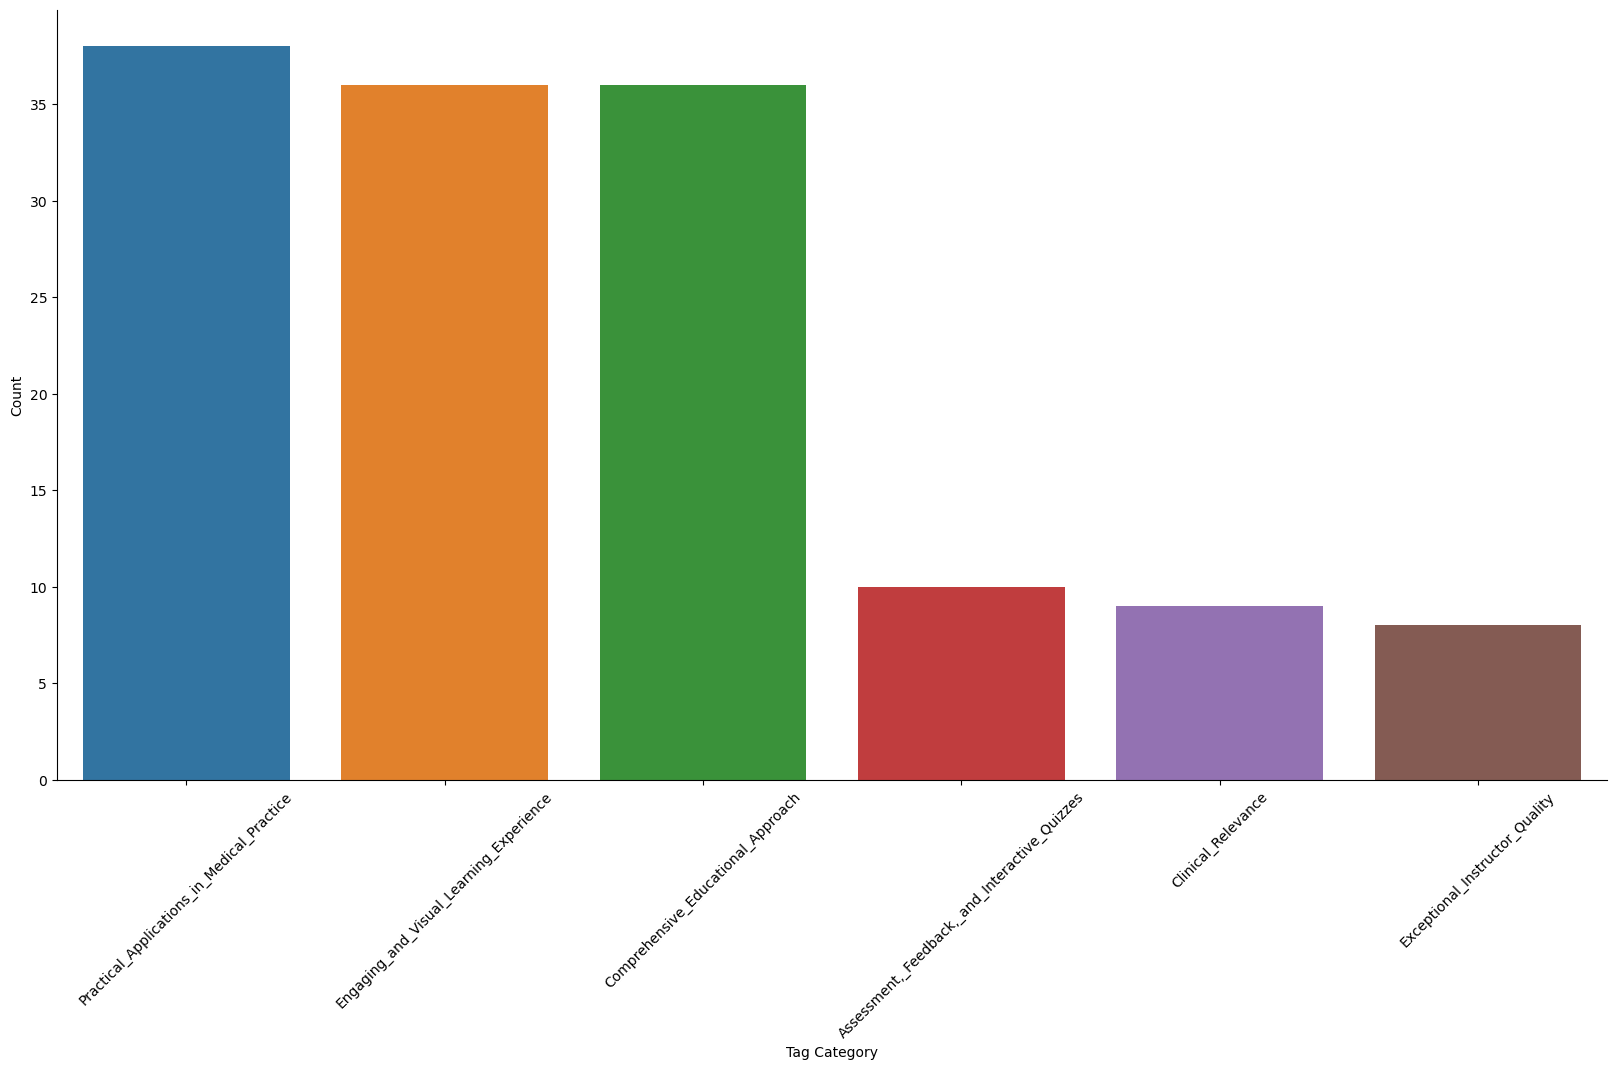

In [113]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=bp_results_df.iloc[:, 2:].sum().sort_values(ascending=False).reset_index(), x='index', y=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.ylabel("Count")
plt.xlabel("Tag Category")
sns.despine(top=True, right=True)
plt.show()

### Multi-label classification (top-down approach)

Here we come in with a set of labels that we've developed and stress-tested that should apply to many types of courses and classify comments based on those categories.

First let's take a look at the predefined tags.

In [11]:
default_tags_list

[{'topic': 'course logistics and fit',
  'description': 'course delivery (policy, support), cost, difficulty, time commitment, grading, credit, schedule, user fit, access, background (e.g. prereqs and appropriateness of course level).'},
 {'topic': 'curriculum',
  'description': 'course content, curriculum, specific topics, course structure.  This focuses on the content and the pedagogical structure of the content, including flow and organization.  This also includes applied material such as clinical cases and case studies. Includes references to pre-recorded discussions between experts or between a doctor and a patient. Includes specific suggestions for additional courses or content.'},
 {'topic': 'teaching modality',
  'description': 'video, visual, interactive, animation, step-by-step, deep dive, background builder (the format rather than the content/topic).'},
 {'topic': 'teaching',
  'description': 'instructors, quality of teaching and explanations'},
 {'topic': 'assessment', 'des

Next we do the classification.

In [15]:
mlc_best_parts_topdown = await multilabel_classify(comments=best_parts_comments) 

for comment, classification in zip(best_parts_comments, mlc_best_parts_topdown):
    pprint(comment)
    pprint(json.loads(classification.model_dump_json()))
    print('\n')

processing 100 inputs in batches of 100
sleeping for 30 seconds between batches
starting 0 to 100
completed 0 to 100
elapsed time: 104.84677195549011
('I valued the practical clinical aspects related to immune-related disorders '
 'and their management.')
{'categories': {'assessment': 0,
                'course_logistics_and_fit': 0,
                'curriculum': 1,
                'other': 0,
                'peer_and_teacher_interaction': 0,
                'resources': 0,
                'teaching': 0,
                'teaching_modality': 0},
 'reasoning': 'The comment specifically mentions appreciation for the '
              'practical clinical aspects of the course, which relates '
              'directly to the curriculum content. It does not mention '
              'logistics, teaching methods, assessment methods, resources, or '
              'interactions, so those categories do not apply.'}


'The flexibility to learn at a self-determined speed'
{'categories': {'assessment':

Let's turn the results into a dataframe.

In [16]:
# make a dataframe with comments in one column and the pivoted tag categories as the other columns
td_results_df = pd.DataFrame({'comment': best_parts_comments})
td_values_df = pd.json_normalize([classification.categories.model_dump() for classification in mlc_best_parts_topdown]).applymap(lambda x: x.value)
td_reasoning_df = pd.DataFrame({"reasoning": [classification.reasoning for classification in mlc_best_parts_topdown]})

td_results_df = pd.concat([td_results_df, td_reasoning_df, td_values_df], axis=1)

full_show(td_results_df.head())

,comment,reasoning,course_logistics_and_fit,curriculum,teaching_modality,teaching,assessment,resources,peer_and_teacher_interaction,other
0,I valued the practical clinical aspects related to immune-related disorders and their management.,"The comment specifically mentions appreciation for the practical clinical aspects of the course, which relates directly to the curriculum content. It does not mention logistics, teaching methods, assessment methods, resources, or interactions, so those categories do not apply.",0,1,0,0,0,0,0,0
1,The flexibility to learn at a self-determined speed,"The comment focuses on the ability to learn at one's own pace, which relates to the teaching modality of the course. It suggests that the course allows for individual learning speeds, which is a specific aspect of how the course is taught or structured in terms of delivery.",0,0,1,0,0,0,0,0
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,"The comment praises the educational content and specifically mentions the section on oncology as a highlight, indicating satisfaction with the curriculum. There is no mention of logistics, teaching modality, teaching quality, assessment, resources, or peer and teacher interaction, so these categories do not apply.",0,1,0,0,0,0,0,0
3,Professional growth within the medical sector,"The comment ""Professional growth within the medical sector"" suggests that the feedback is related to the curriculum's relevance to career development or professional advancement in the medical field. However, it does not provide specific details about the course content, teaching methods, resources, or any other category. Therefore, it is somewhat ambiguous and could potentially fit into the 'curriculum' category if interpreted as feedback on the course's relevance to professional growth. Yet, due to the lack of specificity, it might also be considered 'other' because it does not clearly fit into the predefined categories.",0,1,0,0,0,0,0,1
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The comment specifically mentions the use of practical demonstration clips as a teaching method that helped make complex biological principles more understandable. This directly relates to the teaching methods employed in the course, making 'teaching' the appropriate category. Additionally, the mention of connecting biological principles to daily well-being and actions suggests an aspect of the curriculum design that aims to make the content relatable and applicable to real life, which falls under 'curriculum'.",0,1,0,1,0,0,0,0


Now let's plot this one. (Again, this requires you have matplotlib and seaborn installed. Instead of this, feel free to download the dataframe and plot it in your favorite program).

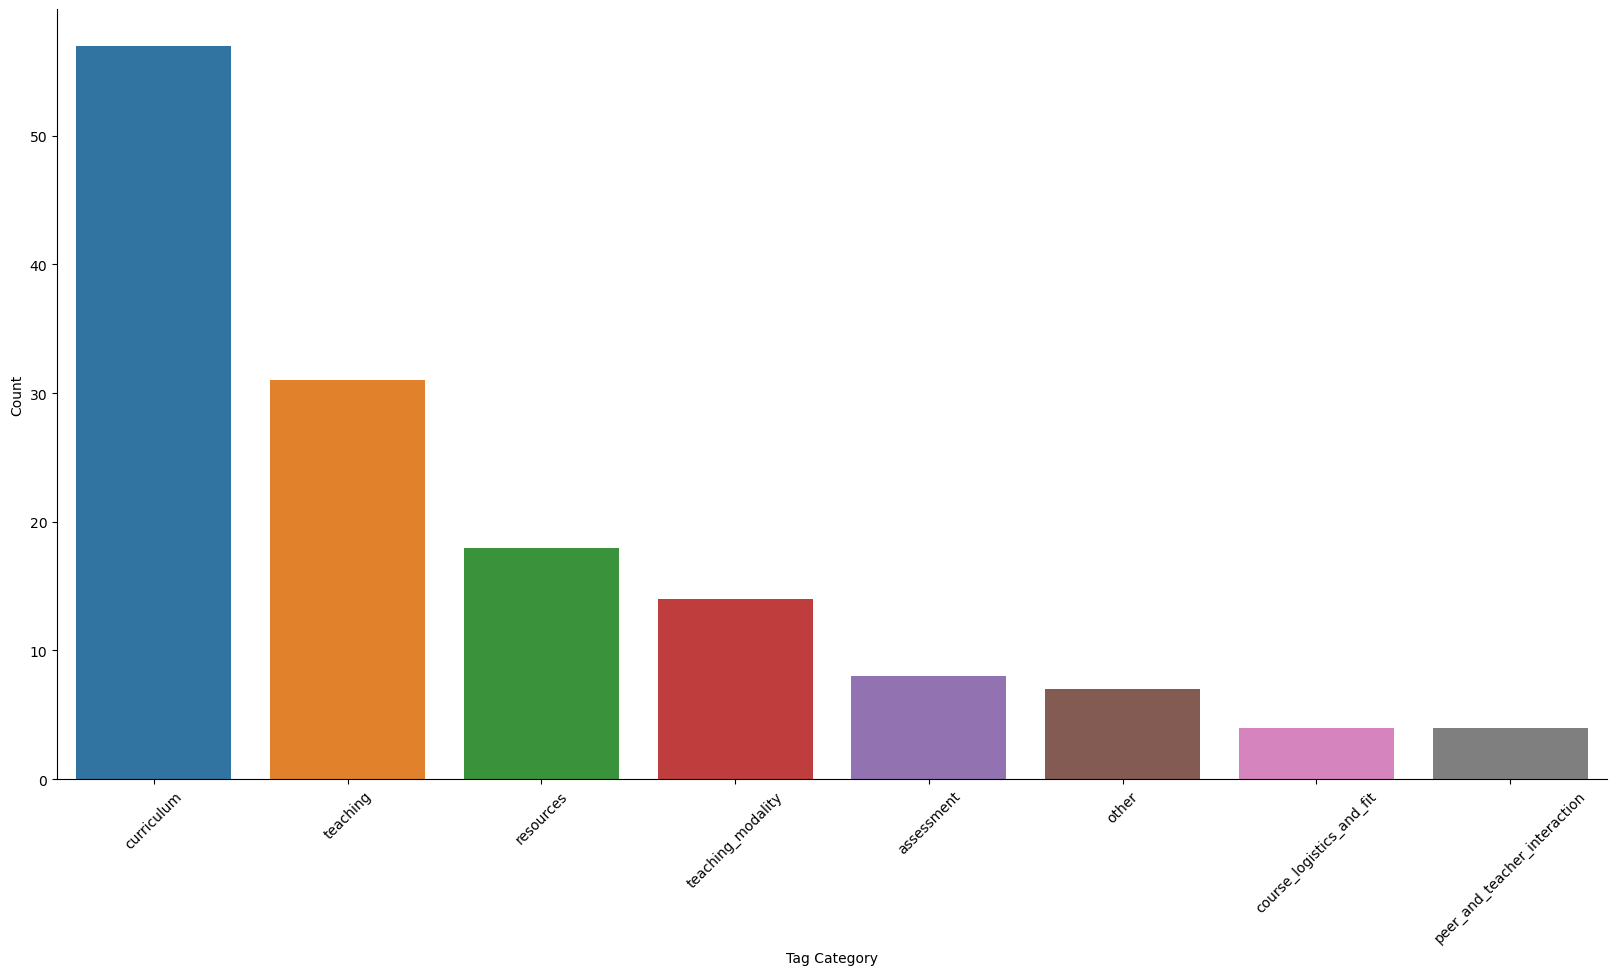

In [17]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=td_results_df.iloc[:, 2:].sum().sort_values(ascending=False).reset_index(), x='index', y=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.ylabel("Count")
plt.xlabel("Tag Category")
sns.despine(top=True, right=True)
plt.show()

Just out of curiosity, let's see what was said in the course_logistics_and_fit category.

In [18]:
for comment in td_results_df.loc[lambda x: x['course_logistics_and_fit'] == 1, 'comment'].to_list():
    print_wrap(f'"{comment}"') # print helper defined under imports and setup
    print('\n')

"The most advantageous aspects of the course included its digital format
and the adaptability regarding the timing for completing various
segments. This flexibility was particularly beneficial for me as a full-
time employee, as it enabled consistent participation in the course that
would have been challenging otherwise."


"The course was informative, though it required more time than
anticipated for those without prior background. Balancing a full-time
job with the additional hours needed for the course was quite demanding,
particularly towards the conclusion when the workload intensified.
Nevertheless, the knowledge gained was substantial, and the delivery by
the educators was of high quality. However, I noticed that certain
examination questions seemed to extend beyond the material covered in
the course. For instance, the classification of certain pathogens and
the specifics of donor-recipient compatibility in medical procedures
were mentioned but not thoroughly explained."


"Expl

It's interesting to be able to zero in on comments like these. It's one thing when you have a small number of comments, but with hundreds or even thousands of feedback comments, having the ability to drill down into results is incredibly helpful.